# Frontiers for Young Minds  – Article Classification

## Text Dataset Preparation

* **Data extraction**

In [ ]:
!unrar x frym.rar /content/frym/

* **Data split** into 3 directories: **train**, **val**idation, and **test** – each of which contains **4 classes**: 'biodiversity', 'earth-and-its-resources', 'human-health', and 'neuroscience-and-psychology'

In [2]:
import os, pathlib, random, shutil

base_dir = pathlib.Path('frym')
data_dir = pathlib.Path('data')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

os.makedirs(data_dir)

sections = ['biodiversity', 
            'earth-and-its-resources', 
            'human-health', 
            'neuroscience-and-psychology'
]

for sec in sections:
    os.makedirs(train_dir / sec)
    os.makedirs(val_dir / sec)
    os.makedirs(test_dir / sec)
    
    files = os.listdir(base_dir / sec)
    random.Random(18).shuffle(files)
    num_train_samples = int(0.7 * len(files)) 
    num_val_samples = int(0.2 * len(files))  
    num_test_samples = int(len(files)-num_train_samples-num_val_samples) 
    
    train_files = files[:num_train_samples]
    val_files = files[num_train_samples:num_train_samples+num_val_samples]
    test_files = files[-num_test_samples:]
    
    for fname in train_files:
        shutil.move(base_dir / sec / fname,
        train_dir / sec / fname)
        
    for fname in val_files:
        shutil.move(base_dir / sec / fname,
        val_dir / sec / fname)
        
    for fname in test_files:
        shutil.move(base_dir / sec / fname,
        test_dir / sec / fname)

* **TensorFlow text datasets:** the inputs are string tensors and the outputs are float tensors (**multi-hot**) encoding the four classes

In [3]:
import tensorflow as tf
from tensorflow import keras

batch_size = 32

train_ds = keras.utils.text_dataset_from_directory('data/train', 
                                                   labels='inferred',
                                                   label_mode='categorical',
                                                   batch_size=batch_size,
                                                   seed=7)

Found 489 files belonging to 4 classes.


In [4]:
val_ds = keras.utils.text_dataset_from_directory('data/val', 
                                                   labels='inferred',
                                                   label_mode='categorical',
                                                   batch_size=batch_size,
                                                   seed=7)

Found 139 files belonging to 4 classes.


In [5]:
test_ds = keras.utils.text_dataset_from_directory('data/test', 
                                                   labels='inferred',
                                                   label_mode='categorical',
                                                   batch_size=batch_size,
                                                   seed=7)

Found 74 files belonging to 4 classes.


* Displaying the shapes and dtypes of the first batch of the **train** dataset

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32, 4)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor(b'ever deep thought hear someone calling name times like minds full thoughts aware going around us often busy thinking going happen later thinking happened earlier thinking happening certainly seem like minds full thoughts mindfulness means mindfulness means aware happening without getting lost thoughts mindfulness helps us become aware going outside inside without distracted thoughts mindfulness fully aware minds see figure need exercise bodies stay physically healthy exercising minds keep us mentally healthy mindfulness involves training attention stay present moment rather following thoughts past future way certain exercises strengthen body muscles mindfulness train brain muscle\xe2\x80\x94attention attention brain way selecting one thing focus wide range things environment brain constantly receiving information world around us five senses well interpreti

## Bag-of-Words Models

### Unigram model

* **Text vectorization:** processing single words (**unigrams**) with multi-hot encoding

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    ngrams=1,
    max_tokens=20000,
    output_mode='multi_hot'
)

* **Vocabulary building** using the TextVectorization layer

In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)
vocabulary = text_vectorization.get_vocabulary()
len(vocabulary)

20000

* **Dataset processing** using the TextVectorization layer

In [ ]:
unigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
unigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
unigram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

* Displaying the shapes and dtypes of the first batch of the **unigram** train dataset

In [ ]:
for inputs, targets in unigram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32, 4)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor([0. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)


* **Model building function** 

In [ ]:
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=24):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

* **Training the unigram model**

In [ ]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 24)                480024    
                                                                 
 dense_1 (Dense)             (None, 4)                 100       
                                                                 
Total params: 480,124
Trainable params: 480,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("unigram.keras", save_best_only=True)]
history = model.fit(unigram_train_ds.cache(),
          validation_data=unigram_val_ds.cache(),
          epochs=4,
          callbacks=callbacks)

Epoch 1/4
16/16 [==============================] - 1s 37ms/step - loss: 0.8118 - accuracy: 0.7035 - val_loss: 0.7060 - val_accuracy: 0.7410
Epoch 2/4
16/16 [==============================] - 0s 12ms/step - loss: 0.1416 - accuracy: 0.9857 - val_loss: 0.4711 - val_accuracy: 0.8345
Epoch 3/4
16/16 [==============================] - 0s 12ms/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0.4497 - val_accuracy: 0.8417
Epoch 4/4
16/16 [==============================] - 0s 12ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.4315 - val_accuracy: 0.8417


* **Testing the unigram model**

In [ ]:
model = keras.models.load_model("unigram.keras")
print(f"Test acc: {model.evaluate(unigram_test_ds)[1]:.3f}")

3/3 [==============================] - 0s 6ms/step - loss: 0.3449 - accuracy: 0.8243
Test acc: 0.824


* Plotting the training and validation loss

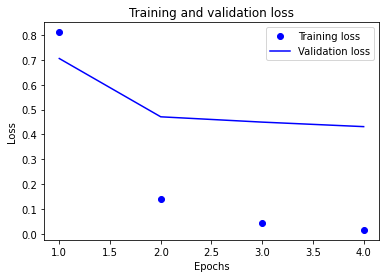

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

* Plotting the training and validation accuracy

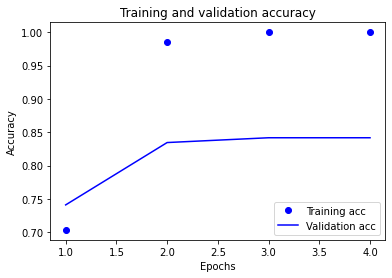

In [ ]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Bigram model

* **Text vectorization:** processing **bigrams** with **multi-hot** encoding

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot"
)

* **Vocabulary building**

In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)
vocabulary = text_vectorization.get_vocabulary()
len(vocabulary)

20000

* **Dataset processing** 

In [ ]:
bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
bigram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

* Displaying the shapes and dtypes of the first batch of the **bigram** train dataset

In [ ]:
for inputs, targets in bigram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32, 4)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor([1. 1. 0. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor([0. 0. 0. 1.], shape=(4,), dtype=float32)


* **Training the bigram model**

In [ ]:
model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 24)                480024    
                                                                 
 dense_3 (Dense)             (None, 4)                 100       
                                                                 
Total params: 480,124
Trainable params: 480,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("bigram.keras", save_best_only=True)]
history = model.fit(bigram_train_ds.cache(),
          validation_data=bigram_val_ds.cache(),
          epochs=4,
          callbacks=callbacks)

Epoch 1/4
16/16 [==============================] - 1s 35ms/step - loss: 0.7561 - accuracy: 0.6892 - val_loss: 0.5455 - val_accuracy: 0.8058
Epoch 2/4
16/16 [==============================] - 0s 12ms/step - loss: 0.1014 - accuracy: 0.9898 - val_loss: 0.4308 - val_accuracy: 0.8705
Epoch 3/4
16/16 [==============================] - 0s 13ms/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.4059 - val_accuracy: 0.8561
Epoch 4/4
16/16 [==============================] - 0s 11ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.3859 - val_accuracy: 0.8633


* **Testing the bigram model**

In [ ]:
model = keras.models.load_model("bigram.keras")
print(f"Test acc: {model.evaluate(bigram_test_ds)[1]:.3f}")

3/3 [==============================] - 0s 6ms/step - loss: 0.3359 - accuracy: 0.8514
Test acc: 0.851


### TF-IDF model ###

* **Text vectorization:** processing **bigrams** with **TF-IDF** encoding

In [ ]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf"
)

* **Vocabulary building**

In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)
vocabulary = text_vectorization.get_vocabulary()
len(vocabulary)

20000

* **Dataset processing** 

In [ ]:
tfidf_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

* Displaying the shapes and dtypes of the first batch of the **TF-IDF** train dataset

In [ ]:
for inputs, targets in tfidf_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32, 4)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor(
[3267.6328       0.           6.3128595 ...    0.           0.
    0.       ], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


* **Training the TF-IDF model**

In [ ]:
model = get_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_4 (Dense)             (None, 24)                480024    
                                                                 
 dense_5 (Dense)             (None, 4)                 100       
                                                                 
Total params: 480,124
Trainable params: 480,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint("tfidf.keras", save_best_only=True)]
history = model.fit(tfidf_train_ds.cache(),
          validation_data=tfidf_val_ds.cache(),
          epochs=4,
          callbacks=callbacks)

Epoch 1/4
16/16 [==============================] - 1s 37ms/step - loss: 2.0117 - accuracy: 0.5910 - val_loss: 0.7081 - val_accuracy: 0.7410
Epoch 2/4
16/16 [==============================] - 0s 10ms/step - loss: 0.2306 - accuracy: 0.9305 - val_loss: 0.5959 - val_accuracy: 0.7914
Epoch 3/4
16/16 [==============================] - 0s 12ms/step - loss: 0.0423 - accuracy: 1.0000 - val_loss: 0.5599 - val_accuracy: 0.7986
Epoch 4/4
16/16 [==============================] - 0s 11ms/step - loss: 0.0182 - accuracy: 1.0000 - val_loss: 0.5636 - val_accuracy: 0.7842


* **Testing the tf-idf model**

In [ ]:
model = keras.models.load_model("tfidf.keras")
print(f"Test acc: {model.evaluate(tfidf_test_ds)[1]:.3f}")

3/3 [==============================] - 0s 6ms/step - loss: 0.5021 - accuracy: 0.8514
Test acc: 0.851


## Sequence Models ##

* **Text vectorization:** processing **single words** with **integer indexing** – each input (aricle) is represented as a sequece of of integer indices (one index per one word)

In [6]:
from tensorflow.keras.layers import TextVectorization

max_length = 1000
max_tokens = 20000

text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length
)

* **Vocabulary building**

In [7]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)
vocabulary = text_vectorization.get_vocabulary()
len(vocabulary)

20000

* **Dataset processing** 

In [8]:
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

* Displaying the shapes and dtypes of the first batch of the **integer** train dataset

In [9]:
for inputs, targets in int_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 1000)
inputs.dtype: <dtype: 'int64'>
targets.shape: (32, 4)
targets.dtype: <dtype: 'float32'>
inputs[0]: tf.Tensor(
[ 1315   251     8  1032  1302   205  1315 12560  6233   706 18902     6
 15639  3638  1158   218   269 14392  1259   434  1315   895   280 10848
   460  6091  2387     6  5088   315  1384  2387     6    95  6091  2387
  3444  2444  5303  2347   373   852    95   343   294   342  2629  2444
  3722  2347  1585   300  1243  2629  2939  1585   864 14058  1243    22
   180  1215    41   373   300   222   294   116  2347   139   330   116
  3676    95  5088  1772   373   720  2837  1554  5705   373   714   127
  5088 14031   234   153   600    95  2216     3   852    95   895   300
   280    44  2331  1890  4214  6414 16450  1860   182   895   280     6
  4214  6414  8611     9    63  1315   820  1032  1834  1259  1384   128
    45  4489  6091   116  4925  2347   720   130    16   759    42   895
   280  5420   820   140   356  1315  6983   294  5303  2347  

## Biderectional LSTM model

### Building biLSTM model: **trained** word embeddings


In [13]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,194,244
Trainable params: 5,194,244
Non-trainable params: 0
_________________________________________________

* **Training the model**

In [14]:
callbacks = [keras.callbacks.ModelCheckpoint("bilstm.keras", save_best_only=True)]
history = model.fit(int_train_ds,
                    validation_data=int_val_ds,
                    epochs=8,
                    callbacks=callbacks)

Epoch 1/8
16/16 [==============================] - 11s 397ms/step - loss: 1.3621 - accuracy: 0.3313 - val_loss: 1.3337 - val_accuracy: 0.3381
Epoch 2/8
16/16 [==============================] - 5s 336ms/step - loss: 1.2196 - accuracy: 0.5215 - val_loss: 1.1468 - val_accuracy: 0.5252
Epoch 3/8
16/16 [==============================] - 5s 325ms/step - loss: 0.8620 - accuracy: 0.6810 - val_loss: 1.2718 - val_accuracy: 0.5540
Epoch 4/8
16/16 [==============================] - 5s 333ms/step - loss: 0.7593 - accuracy: 0.7628 - val_loss: 0.9654 - val_accuracy: 0.6547
Epoch 5/8
16/16 [==============================] - 5s 321ms/step - loss: 0.6288 - accuracy: 0.8446 - val_loss: 0.9708 - val_accuracy: 0.6763
Epoch 6/8
16/16 [==============================] - 5s 331ms/step - loss: 0.4962 - accuracy: 0.9100 - val_loss: 0.9206 - val_accuracy: 0.6619
Epoch 7/8
16/16 [==============================] - 5s 329ms/step - loss: 0.3876 - accuracy: 0.9530 - val_loss: 0.9109 - val_accuracy: 0.6835
Epoch 8/8
16

* **Testing the model**

In [15]:
model = keras.models.load_model("bilstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

3/3 [==============================] - 1s 112ms/step - loss: 0.8738 - accuracy: 0.6892
Test acc: 0.689


### Building biLSTM model: **trained** word embeddings & **masked zeros**

In [16]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,194,244
Trainable params: 5,194,244
Non-trainable params: 0
_________________________________________________

* **Training the model**

In [17]:
callbacks = [keras.callbacks.ModelCheckpoint("bilstm_mask.keras", save_best_only=True)]
history = model.fit(int_train_ds,
                    validation_data=int_val_ds,
                    epochs=8,
                    callbacks=callbacks)

Epoch 1/8
16/16 [==============================] - 19s 562ms/step - loss: 1.3341 - accuracy: 0.3845 - val_loss: 1.2363 - val_accuracy: 0.5827
Epoch 2/8
16/16 [==============================] - 6s 347ms/step - loss: 0.9025 - accuracy: 0.7280 - val_loss: 0.8590 - val_accuracy: 0.6547
Epoch 3/8
16/16 [==============================] - 6s 344ms/step - loss: 0.5740 - accuracy: 0.8078 - val_loss: 0.8048 - val_accuracy: 0.6691
Epoch 4/8
16/16 [==============================] - 6s 344ms/step - loss: 0.4326 - accuracy: 0.8446 - val_loss: 0.8024 - val_accuracy: 0.6978
Epoch 5/8
16/16 [==============================] - 5s 339ms/step - loss: 0.2797 - accuracy: 0.9407 - val_loss: 0.7992 - val_accuracy: 0.7338
Epoch 6/8
16/16 [==============================] - 5s 337ms/step - loss: 0.1972 - accuracy: 0.9775 - val_loss: 0.7821 - val_accuracy: 0.7770
Epoch 7/8
16/16 [==============================] - 5s 333ms/step - loss: 0.1214 - accuracy: 0.9939 - val_loss: 0.8975 - val_accuracy: 0.7698
Epoch 8/8
16

* **Testing the model**

In [19]:
model = keras.models.load_model("bilstm_mask.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

3/3 [==============================] - 3s 114ms/step - loss: 0.6210 - accuracy: 0.7838
Test acc: 0.784


### Building biLSTM model: **pre-trained** word embeddings

#### **GloVe** word embeddings

* **GloVe file download & extraction**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

* **Parsing the GloVe 100d file:** 100-dimensional embedding vectors for 400,000 words 

In [24]:
import numpy as np

path_to_glove_file = "glove.6B.100d.txt"
embeddings_index = {}

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.



* **Preparing the GloVe word-embeddings matrix**

In [32]:
embeddings_index.get('bacteria')

array([-0.70408  ,  0.1314   ,  0.05967  , -0.53633  , -0.60984  ,
       -0.039942 ,  0.32678  , -1.0457   ,  0.35869  , -0.074033 ,
       -0.067529 , -0.21356  ,  0.42285  ,  0.70801  ,  0.60047  ,
        0.052051 , -0.40979  , -0.0026012, -0.15161  , -0.17906  ,
        0.27603  , -0.50553  ,  0.30125  , -0.15001  , -0.076313 ,
        0.45314  ,  0.79745  , -0.23991  , -0.019936 ,  0.18393  ,
        0.46779  ,  0.77197  ,  0.30393  , -0.43825  ,  0.98218  ,
        0.037555 , -0.16977  , -1.1405   , -0.09597  ,  0.3565   ,
       -0.35233  , -0.27088  , -1.5643   , -0.62088  ,  1.2465   ,
        0.95036  , -0.14111  , -0.24287  , -0.91673  ,  0.035896 ,
        0.90314  , -0.22453  , -0.25608  , -0.059836 , -0.647    ,
       -0.2498   , -0.093719 , -0.31185  ,  0.49059  ,  0.71524  ,
       -0.26315  ,  1.1332   ,  0.86974  ,  0.13102  ,  1.0317   ,
        1.6044   ,  0.52005  , -0.87881  ,  0.70383  , -1.4546   ,
       -0.024927 , -0.11402  , -0.13185  ,  0.42752  , -0.0465